# Sentiment Analysis on Yelp Reviews with LSTM and Optuna Hyperparameter Optimization

## Overview
This project aims to perform sentiment analysis on Yelp reviews using a deep learning model based on LSTM layers. The primary objective is to classify reviews into three sentiment classes: negative, neutral, and positive. The project leverages Optuna for hyperparameter optimization to enhance the model's performance.

## Workflow

### 1. Data Loading
The Yelp dataset, containing reviews and ratings, is loaded from a CSV file. The file is read into a pandas DataFrame using the following command:

df = pd.read_csv('/path/to/your/Yelp Restaurant Reviews.csv')


Replace the file path with the actual path where your dataset is stored.

### 2. Sentiment Mapping
The ratings in the dataset are mapped to sentiment classes:

0: Negative (1 and 2 stars)
1: Neutral (3 stars)
2: Positive (4 and 5 stars)
This is done using a lambda function applied to the Rating column:
df['Sentiment'] = df['Rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

### 3. Data Splitting
The dataset is split into training and test sets using an 80-20 ratio. The train_test_split function from scikit-learn is used:

X_train, X_test, y_train, y_test = train_test_split(df['Review Text'], df['Sentiment'], test_size=0.2, random_state=42)

### 4. Text Tokenization
The text data is tokenized using Keras' Tokenizer. The vocabulary size is set to 20,000, and the text is converted to sequences of tokens:

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

### 5. Sequence Padding
The sequences are padded to ensure they all have the same length, which is necessary for the LSTM model:

trainX = pad_sequences(sequences_train)
T = trainX.shape[1]  # Maximum length of the sequences
testX = pad_sequences(sequences_test, maxlen=T)

The Optuna objective function defines the model architecture, compiles the model, and trains it. Early stopping is used to prevent overfitting.

### 7. Training and Evaluation
The model is trained on the training set and evaluated on the test set. Validation accuracy is monitored and printed for each epoch during the optimization process. After optimization, the best hyperparameters are used to train a final model.

### 8. Visualization
The training and validation accuracy, along with the loss, are visualized to understand the model's performance over epochs.

## Conclusion
This workflow efficiently leverages Optuna to fine-tune the LSTM model's hyperparameters, leading to an optimized sentiment analysis model for Yelp reviews. The steps outlined can be used as a reference for future projects involving deep learning and hyperparameter optimization.

In [1]:
!pip install optuna

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:

# Load the Yelp dataset from a CSV file
file_path = '/content/drive/My Drive/Yelp Restaurant Reviews.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Map ratings to sentiments: 0 = negative, 1 = neutral, 2 = positive
df['Sentiment'] = df['Rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Review Text'], df['Sentiment'], test_size=0.2, random_state=42)

# Tokenize the text
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# Convert sequences to fixed-length sequences using padding
trainX = pad_sequences(sequences_train)
T = trainX.shape[1]  # Maximum length of the sequences
testX = pad_sequences(sequences_test, maxlen=T)

# Word index mapping
word2idx = tokenizer.word_index
V = len(word2idx)  # Vocabulary size

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU not available, using CPU.")


GPU is available.


In [16]:
import optuna
from tensorflow.keras.layers import Dropout, LSTM, Dense, Input, GlobalMaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU not available, using CPU.")

# Assuming your Yelp dataset is already preprocessed and available as `trainX`, `y_train`, `testX`, `y_test`

# Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    embedding_dim = trial.suggest_categorical('embedding_dim', [15, 20, 25, 30])
    lstm_units_1 = trial.suggest_categorical('lstm_units_1', [32, 64, 128])
    lstm_units_2 = trial.suggest_categorical('lstm_units_2', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])

    with tf.device('/GPU:0'):  # Ensure GPU is used if available
        i = Input(shape=(T,))
        x = Embedding(V + 1, embedding_dim)(i)
        x = LSTM(lstm_units_1, return_sequences=True)(x)  # First LSTM layer
        x = Dropout(dropout_rate)(x)
        x = LSTM(lstm_units_2, return_sequences=True)(x)  # Second LSTM layer with different units
        x = Dropout(dropout_rate)(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(3, activation='softmax')(x)  # 3 classes for positive, neutral, and negative
        model = Model(i, x)

        # Compile the model
        model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

        # Train the model and show validation accuracy for each epoch
        hist = model.fit(
            trainX, y_train,
            epochs=10,
            batch_size=batch_size,  # Batch size is now a hyperparameter
            validation_data=(testX, y_test),
            callbacks=[early_stopping],
            verbose=1  # Set verbose=1 to show progress and accuracy for each epoch
        )

        # Print validation accuracy for each epoch within the trial
        for epoch, val_acc in enumerate(hist.history['val_accuracy'], 1):
            print(f"Trial {trial.number}, Epoch {epoch}, Validation Accuracy: {val_acc:.4f}")

        # Evaluate the model
        loss, accuracy = model.evaluate(testX, y_test, verbose=0)
        return accuracy


GPU is available.


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
# Create and optimize the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Best trial
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Visualize the optimization history
optuna.visualization.plot_optimization_history(study).show()




[I 2024-08-13 15:29:17,246] A new study created in memory with name: no-name-774b9d12-4d3c-4a20-ba18-10f68f4cbe68


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.7549 - loss: 0.7771 - val_accuracy: 0.7696 - val_loss: 0.7088
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.7711 - loss: 0.6965 - val_accuracy: 0.7696 - val_loss: 0.7036
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.7708 - loss: 0.6967 - val_accuracy: 0.7696 - val_loss: 0.7060
Trial 0, Epoch 1, Validation Accuracy: 0.7696
Trial 0, Epoch 2, Validation Accuracy: 0.7696
Trial 0, Epoch 3, Validation Accuracy: 0.7696


[I 2024-08-13 15:30:44,538] Trial 0 finished with value: 0.7695980072021484 and parameters: {'embedding_dim': 25, 'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate': 0.1, 'learning_rate': 0.000256274047619699, 'batch_size': 64}. Best is trial 0 with value: 0.7695980072021484.


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.7513 - loss: 0.7401 - val_accuracy: 0.7696 - val_loss: 0.6849
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.7900 - loss: 0.5631 - val_accuracy: 0.8324 - val_loss: 0.4334
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.8573 - loss: 0.3587 - val_accuracy: 0.8533 - val_loss: 0.3847
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.8833 - loss: 0.2872 - val_accuracy: 0.8548 - val_loss: 0.3786
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9103 - loss: 0.2236 - val_accuracy: 0.8543 - val_loss: 0.3921
Trial 1, Epoch 1, Validation Accuracy: 0.7696
Trial 1, Epoch 2, Validation Accuracy: 0.8324
Trial 1, Epoch 3, Validation Accuracy: 0.8533
Trial 1, Epoch 4, Validation Accuracy: 0.8548
Trial 1, Epoch 5, Validation Accuracy: 0.8543


[I 2024-08-13 15:33:08,067] Trial 1 finished with value: 0.8547738790512085 and parameters: {'embedding_dim': 15, 'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0013776954701494887, 'batch_size': 64}. Best is trial 1 with value: 0.8547738790512085.


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.7512 - loss: 0.8597 - val_accuracy: 0.7696 - val_loss: 0.7261
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.7672 - loss: 0.7015 - val_accuracy: 0.7696 - val_loss: 0.7177
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.7708 - loss: 0.6973 - val_accuracy: 0.7696 - val_loss: 0.7301
Trial 2, Epoch 1, Validation Accuracy: 0.7696
Trial 2, Epoch 2, Validation Accuracy: 0.7696
Trial 2, Epoch 3, Validation Accuracy: 0.7696


[I 2024-08-13 15:34:14,046] Trial 2 finished with value: 0.7695980072021484 and parameters: {'embedding_dim': 20, 'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.00012255861168988447, 'batch_size': 64}. Best is trial 1 with value: 0.8547738790512085.


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.7556 - loss: 0.7093 - val_accuracy: 0.7877 - val_loss: 0.6020
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.8241 - loss: 0.4442 - val_accuracy: 0.8415 - val_loss: 0.4122
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.8740 - loss: 0.2986 - val_accuracy: 0.8530 - val_loss: 0.3690
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.9074 - loss: 0.2330 - val_accuracy: 0.8510 - val_loss: 0.3834
Trial 3, Epoch 1, Validation Accuracy: 0.7877
Trial 3, Epoch 2, Validation Accuracy: 0.8415
Trial 3, Epoch 3, Validation Accuracy: 0.8530
Trial 3, Epoch 4, Validation Accuracy: 0.8510


[I 2024-08-13 15:36:11,290] Trial 3 finished with value: 0.8530150651931763 and parameters: {'embedding_dim': 25, 'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate': 0.2, 'learning_rate': 0.007289846511521691, 'batch_size': 64}. Best is trial 1 with value: 0.8547738790512085.


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.7657 - loss: 0.8057 - val_accuracy: 0.7696 - val_loss: 0.7056
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.7650 - loss: 0.7074 - val_accuracy: 0.7696 - val_loss: 0.7005
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.7644 - loss: 0.6732 - val_accuracy: 0.8309 - val_loss: 0.4854
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.8429 - loss: 0.4328 - val_accuracy: 0.8467 - val_loss: 0.4092
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.8563 - loss: 0.3603 - val_accuracy: 0.8540 - val_loss: 0.3893
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.8740 - loss: 0.3185 - val_accuracy: 0.8475 - val_loss: 0.3941
Trial 4, Epoch 1, Validation Accuracy: 0.7696
Trial 4, Epoch 2, Validation Accuracy: 0.7696
Trial 4, Epoch 3, Validation Accuracy: 0.8309
Trial 4, Epoch 4, Validation Accuracy: 0.8467
Trial 4, Epoch 5, Validation Accurac

[I 2024-08-13 15:38:19,308] Trial 4 finished with value: 0.8540201187133789 and parameters: {'embedding_dim': 25, 'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.1, 'learning_rate': 0.00019566851617947817, 'batch_size': 64}. Best is trial 1 with value: 0.8547738790512085.


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.7564 - loss: 0.7730 - val_accuracy: 0.7696 - val_loss: 0.7089
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.7882 - loss: 0.6065 - val_accuracy: 0.8407 - val_loss: 0.4320
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.8502 - loss: 0.3721 - val_accuracy: 0.8417 - val_loss: 0.3973
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.8720 - loss: 0.3097 - val_accuracy: 0.8425 - val_loss: 0.3824
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.8945 - loss: 0.2678 - val_accuracy: 0.8505 - val_loss: 0.3998
Trial 5, Epoch 1, Validation Accuracy: 0.7696
Trial 5, Epoch 2, Validation Accuracy: 0.8407
Trial 5, Epoch 3, Validation Accuracy: 0.8417
Trial 5, Epoch 4, Validation Accuracy: 0.8425
Trial 5, Epoch 5, Validation Accuracy: 0.8505


[I 2024-08-13 15:40:06,322] Trial 5 finished with value: 0.8424623012542725 and parameters: {'embedding_dim': 20, 'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0004519655629885417, 'batch_size': 64}. Best is trial 1 with value: 0.8547738790512085.


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.7563 - loss: 0.7364 - val_accuracy: 0.8171 - val_loss: 0.5015
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8242 - loss: 0.4547 - val_accuracy: 0.8440 - val_loss: 0.3937
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8773 - loss: 0.3206 - val_accuracy: 0.8533 - val_loss: 0.3827
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.8908 - loss: 0.2753 - val_accuracy: 0.8533 - val_loss: 0.3793
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9104 - loss: 0.2291 - val_accuracy: 0.8420 - val_loss: 0.4125
Trial 6, Epoch 1, Validation Accuracy: 0.8171
Trial 6, Epoch 2, Validation Accuracy: 0.8440
Trial 6, Epoch 3, Validation Accuracy: 0.8533
Trial 6, Epoch 4, Validation Accuracy: 0.8533
Trial 6, Epoch 5, Validation Accuracy: 0.8420


[I 2024-08-13 15:42:15,510] Trial 6 finished with value: 0.8532663583755493 and parameters: {'embedding_dim': 20, 'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0006389413032535631, 'batch_size': 64}. Best is trial 1 with value: 0.8547738790512085.


Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.7746 - loss: 0.6551 - val_accuracy: 0.8382 - val_loss: 0.4193
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8630 - loss: 0.3349 - val_accuracy: 0.8543 - val_loss: 0.3757
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8938 - loss: 0.2552 - val_accuracy: 0.8500 - val_loss: 0.3744
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.9261 - loss: 0.1872 - val_accuracy: 0.8420 - val_loss: 0.4041
Trial 7, Epoch 1, Validation Accuracy: 0.8382
Trial 7, Epoch 2, Validation Accuracy: 0.8543
Trial 7, Epoch 3, Validation Accuracy: 0.8500
Trial 7, Epoch 4, Validation Accuracy: 0.8420


[I 2024-08-13 15:45:04,893] Trial 7 finished with value: 0.8500000238418579 and parameters: {'embedding_dim': 15, 'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.006202309537919874, 'batch_size': 32}. Best is trial 1 with value: 0.8547738790512085.


Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.7695 - loss: 0.7265 - val_accuracy: 0.8309 - val_loss: 0.4734
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.8435 - loss: 0.4001 - val_accuracy: 0.8505 - val_loss: 0.3962
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8698 - loss: 0.3141 - val_accuracy: 0.8533 - val_loss: 0.3814
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.8958 - loss: 0.2609 - val_accuracy: 0.8495 - val_loss: 0.3803
Epoch 5/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.9159 - loss: 0.2218 - val_accuracy: 0.8354 - val_loss: 0.4029
Trial 8, Epoch 1, Validation Accuracy: 0.8309
Trial 8, Epoch 2, Validation Accuracy: 0.8505
Trial 8, Epoch 3, Validation Accuracy: 0.8533
Trial 8, Epoch 4, Validation Accuracy: 0.8495
Trial 8, Epoch 5, Validation Accuracy: 0.8354


[I 2024-08-13 15:48:23,908] Trial 8 finished with value: 0.8494974970817566 and parameters: {'embedding_dim': 20, 'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0004992393723690642, 'batch_size': 32}. Best is trial 1 with value: 0.8547738790512085.


Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.7562 - loss: 0.7332 - val_accuracy: 0.7696 - val_loss: 0.7050
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.8037 - loss: 0.5467 - val_accuracy: 0.8387 - val_loss: 0.4321
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.8672 - loss: 0.3274 - val_accuracy: 0.8440 - val_loss: 0.3880
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.8883 - loss: 0.2679 - val_accuracy: 0.8420 - val_loss: 0.3988
Trial 9, Epoch 1, Validation Accuracy: 0.7696
Trial 9, Epoch 2, Validation Accuracy: 0.8387
Trial 9, Epoch 3, Validation Accuracy: 0.8440
Trial 9, Epoch 4, Validation Accuracy: 0.8420


[I 2024-08-13 15:51:06,173] Trial 9 finished with value: 0.8439698219299316 and parameters: {'embedding_dim': 20, 'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0006028764536872, 'batch_size': 32}. Best is trial 1 with value: 0.8547738790512085.


Best trial:
  Value: 0.8547738790512085
  Params: 
    embedding_dim: 15
    lstm_units_1: 128
    lstm_units_2: 64
    dropout_rate: 0.1
    learning_rate: 0.0013776954701494887
    batch_size: 64


In [18]:

# Train the final model with the best parameters found
best_params = trial.params
embedding_dim = best_params['embedding_dim']
lstm_units_1 = best_params['lstm_units_1']
lstm_units_2 = best_params['lstm_units_2']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']

#early stopping:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

with tf.device('/GPU:0'):  # Ensure GPU is used if available
    i = Input(shape=(T,))
    x = Embedding(V + 1, embedding_dim)(i)
    x = LSTM(lstm_units_1, return_sequences=True)(x)  # First LSTM layer
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units_2, return_sequences=True)(x)  # Second LSTM layer with different units
    x = Dropout(dropout_rate)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(3, activation='softmax')(x)  # 3 classes for positive, neutral, and negative
    model = Model(i, x)

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # Train the model with the best hyperparameters
    hist = model.fit(trainX, y_train, epochs=10, batch_size=batch_size, validation_data=(testX, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.7581 - loss: 0.7419 - val_accuracy: 0.7696 - val_loss: 0.7218
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.7707 - loss: 0.6965 - val_accuracy: 0.8035 - val_loss: 0.5263
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8303 - loss: 0.4452 - val_accuracy: 0.8460 - val_loss: 0.4045
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8682 - loss: 0.3336 - val_accuracy: 0.8432 - val_loss: 0.4047


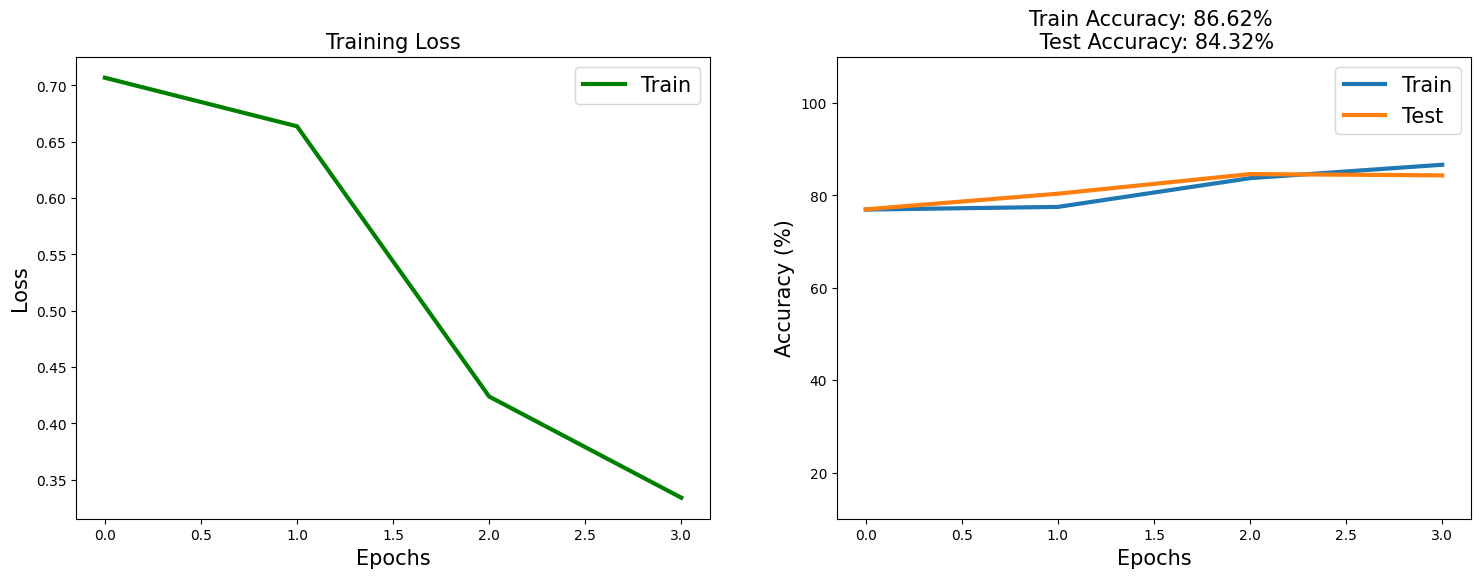

In [19]:
import matplotlib.pyplot as plt

# Visualizing the Performance of Model
trainAcc = [100 * x for x in hist.history['accuracy']]
testAcc = [100 * x for x in hist.history['val_accuracy']]

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(hist.history['loss'], 'g', lw=3, label='Train')
ax[0].set_xlabel('Epochs', fontsize=15)
ax[0].set_ylabel('Loss', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].set_title('Training Loss', fontsize=15)

ax[1].plot(trainAcc, label='Train', lw=3)
ax[1].plot(testAcc, label='Test', lw=3)
ax[1].set_xlabel('Epochs', fontsize=15)
ax[1].set_ylabel('Accuracy (%)', fontsize=15)
ax[1].set_ylim([10, 110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize=15)
ax[1].legend(fontsize=15)

plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


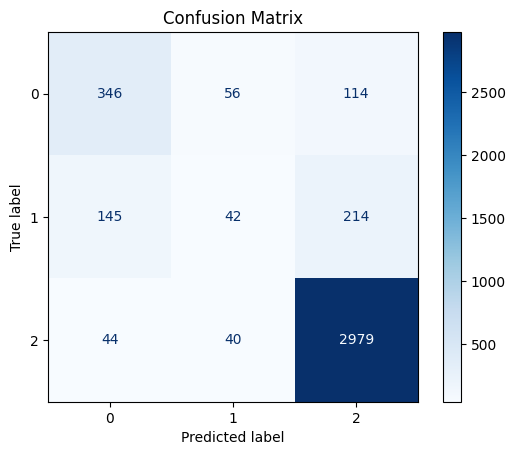

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict classes for the test set
y_pred = model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded output to class labels

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])  # 0: Negative, 1: Neutral, 2: Positive
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [21]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive'])

# Print the classification report
print(report)


              precision    recall  f1-score   support

    Negative       0.65      0.67      0.66       516
     Neutral       0.30      0.10      0.16       401
    Positive       0.90      0.97      0.94      3063

    accuracy                           0.85      3980
   macro avg       0.62      0.58      0.58      3980
weighted avg       0.81      0.85      0.82      3980

